# Shipment Forecast

In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error as mae, mean_absolute_percentage_error as mape
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV 
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator

from scipy.optimize import minimize
from boruta import BorutaPy

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

import xgboost as xgb
import lightgbm as lgb

from fbprophet import Prophet

import logging
logging.getLogger('fbprophet').setLevel(logging.WARNING) 

## Data loading

In [3]:
pos_data = pd.read_csv('data/pos.csv')
pos_data.head()

,Date,Sales
0,2011-01-01,266.0
1,2011-02-01,145.9
2,2011-03-01,183.1
3,2011-04-01,119.3
4,2011-05-01,180.3


In [4]:
promo_data = pd.read_csv('data/promo.csv', header=None)
promo_data.head()

,0,1
0,2011-11-01,BlackFriday
1,2012-11-01,BlackFriday
2,2013-11-01,BlackFriday


In [5]:
shipment_data = pd.read_csv('data/shipment.csv')
shipment_data.head()

,Date,Shipments
0,2011-01-01,100
1,2011-02-01,319
2,2011-03-01,247
3,2011-04-01,238
4,2011-05-01,214


## Data exploration

### Set Date as index

In [6]:
pos_data.Date = pd.to_datetime(pos_data.Date)

promo_data.rename({0:'Date', 1:'BlackFriday'}, axis=1, inplace=True)
promo_data.Date = pd.to_datetime(promo_data.Date)

shipment_data.Date = pd.to_datetime(shipment_data.Date)

In [7]:
pos_data = pos_data.set_index('Date')
promo_data = promo_data.set_index('Date')
shipment_data = shipment_data.set_index('Date')

### Missing values

In [8]:
pos_data.isna().sum()

Sales    0
dtype: int64

In [9]:
promo_data.isna().sum()

BlackFriday    0
dtype: int64

In [10]:
shipment_data.isna().sum()

Shipments    0
dtype: int64

### Missing month

In [11]:
pos_data.asfreq('MS').isna().sum()

Sales    0
dtype: int64

In [12]:
shipment_data.asfreq('MS').isna().sum()

Shipments    0
dtype: int64

### Combine dataframes into one

In [13]:
data = pd.concat([pos_data, promo_data, shipment_data], axis=1)
data.BlackFriday = data.BlackFriday.replace("BlackFriday", 1)
data = data.fillna(0)
data

,Sales,BlackFriday,Shipments
Date,,,
2011-01-01,266.0,0.0,100
2011-02-01,145.9,0.0,319
2011-03-01,183.1,0.0,247
2011-04-01,119.3,0.0,238
2011-05-01,180.3,0.0,214
2011-06-01,168.5,0.0,188
2011-07-01,231.8,0.0,195
2011-08-01,224.5,0.0,209
2011-09-01,192.8,0.0,241


### Sales and Shipments time-series graph

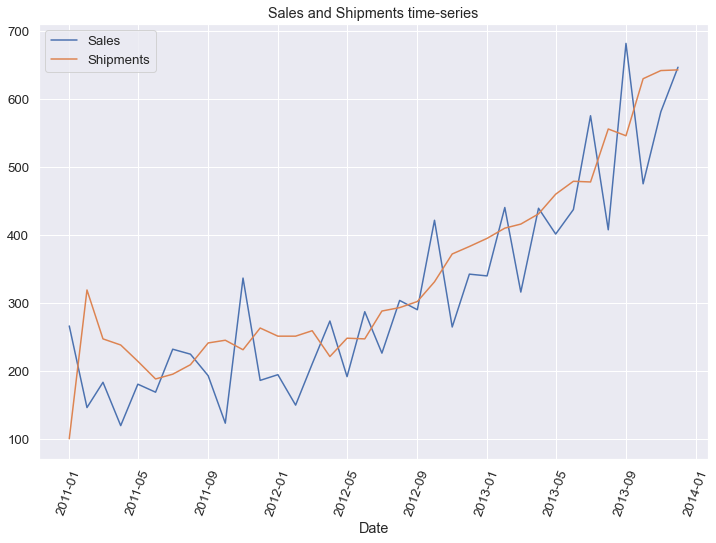

In [14]:
sns.set_style('darkgrid')
sns.set(font_scale = 1.2)

plt.figure(figsize=(12,8))
plt.title('Sales and Shipments time-series')
sns.lineplot(x='Date', y='Sales', data=data, label='Sales')
sns.lineplot(x='Date', y='Shipments', data=data, label='Shipments')
plt.legend()
plt.ylabel('')
plt.xticks(rotation=70);

- Since we have `BlackFridays` each November we would expect increasing of `Sales` this month. This graph hardly tells us that `Sales` increase each November, so we'll do time-series decomposition to clearly see the trend and seasonality.
- Sometimes `Shipments` are less than `Sales`, that may mean we have goods in stock.

### Time-series components

### <font color='red'>?</font> 
How decomposition works? Why we need to decompose? Reason behind Multiplicative Decompose? When it should be applied?

In [ ]:
sales_decomp_add = seasonal_decompose(pos_data.Sales)
sales_decomp_mul = seasonal_decompose(pos_data.Sales, model='multiplicative')
plt.rcParams.update({'figure.figsize': (10,8)})

sales_decomp_add.plot().suptitle('Additive Decompose')
plt.tight_layout(rect=[0, 0, 0.95, 1])

sales_decomp_mul.plot().suptitle('Multiplicative Decompose')
plt.tight_layout(rect=[0, 0, 0.95, 1])
plt.show()

We clearly see upward trend and some spikes in November (due to BlackFridays), April (probably due to Easter).

In [ ]:
shipment_decomp_add = seasonal_decompose(shipment_data.Shipments)
shipment_decomp_mul = seasonal_decompose(shipment_data.Shipments, model='multiplicative')
plt.rcParams.update({'figure.figsize': (10,8)})

shipment_decomp_add.plot().suptitle('Additive Decompose')
plt.tight_layout(rect=[0, 0, 0.95, 1])

shipment_decomp_mul.plot().suptitle('Multiplicative Decompose')
plt.tight_layout(rect=[0, 0, 0.95, 1])
plt.show()

There's also upward trend and spikes are in May and December. I may assume that Shipments increases these month to replenish stock after big Sales in April and November.

## Moving average

As a baseline model we'll use a **Simple Moving Average** (SMA) with different window's sizes. SMA is a rolling mean of the recent observations over a specific number of time periods. We'll calculate metrics MAPE and MAE using time series cross validation with 5 folds (we're going to evaluate the last 5 month individually).

In [15]:
def ma():
    predicted_values = []
    values = data.Shipments
    mae_errors, mape_errors = [], [] 
    eval_result = {}
    
    tscv = TimeSeriesSplit(n_splits=5, test_size=1) 
    for train, test in tscv.split(values):
        rolling_mean = values[train].rolling(window=window).mean()[-1]
        predicted_values.append(rolling_mean)
        
        mae_errors.append(mae(values[test].tolist(), np.array([rolling_mean])))
        mape_errors.append(mape(values[test].tolist(), np.array([rolling_mean])))
        
    mae_errors = np.mean(np.array(mae_errors))
    mape_errors = np.mean(np.array(mape_errors))
    
    eval_result['predicted'] = predicted_values
    eval_result['mape'] = mape_errors
    eval_result['mae'] = mae_errors
    
    return eval_result

For window = 1:
mape = 0.06243658403418294
mae = 37.0

For window = 2:
mape = 0.08257949738502555
mae = 49.3

For window = 3:
mape = 0.10981660400676604
mae = 66.06666666666668

For window = 4:
mape = 0.133000794025731
mae = 80.2



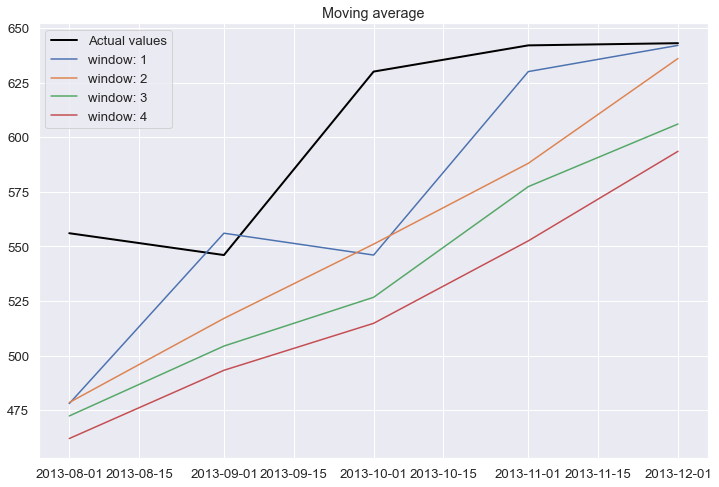

In [16]:
window_sizes = [1, 2, 3, 4]
plt.figure(figsize=(12,8))
plt.title('Moving average')
plt.plot(data.Shipments[-5:], label='Actual values', color='black', linewidth=2)

for window in window_sizes:
    eval_results = ma()
    mape_error = eval_results['mape']
    mae_error = eval_results['mae']
    predicted_values = eval_results['predicted']
    print(f'For window = {window}:\nmape = {mape_error}\nmae = {mae_error}\n')
    plt.plot(data.Shipments[-5:].index, predicted_values, label=f'window: {window}')

    
plt.legend(loc='best')
plt.show()

The window of 1 means that `Shipments` in the next month will be the same as in the past. As we expand our window for rolling mean calculations we get worse results of error metrics. Baseline model shows that we can get MAPE of **6.24%**. Though it's simple but it's far from perfect. Let's improve our results using Exponential Smoothing.

## Exponential Smoothing

SMA assigns equal weight to all values but now let's weight all available observations while exponentially decreasing the weights as we move further back in time. We'll start with simple idea of exponential smoothing.

### Simple exponential smoothing

The mathematical notation for this method is: $$\hat{y}_x = \alpha y_x + (1 - \alpha)\hat{y}_{x-1}$$ 

So we pick an  $0 < \alpha < 1$ (also called **the smoothing factor**) and a starting value $\hat{y}_0$ (the first value of the observed data) and then calculate $\hat{y}_x$ for $x = \overline{1, n}$ (also referred to as **levels**). <br> $\alpha$ defines **how quickly we forget the last available true observation.** The smaller $\alpha$ is, the more influence the previous historical observations have and the smoother the series is, whereas larger values of $\alpha$ mean that the model pays attention mainly to the most recent past observations.

### <font color='red'>?</font>
What is `x` parameter? Which data is used to evaluate the model? How predictions are evaluated? 

### <font color='red'>!</font>
A possibility to substitute data is generally better for code reusability.

Check out `sklearn.model_selection.cross_val_score` in combination with `sklearn.pipeline`.

In [75]:
def exp_smooth_score(x):
    mape_errors = []
    mae_errors = []
    predicted_values = []
    eval_result = {}
    values = data.Shipments.values
    
    tscv = TimeSeriesSplit(n_splits=5, test_size=1) 
    for train, test in tscv.split(values):
        
        if len(x) == 1:
            alpha = x
            model = SimpleExpSmoothing(values[train]).fit(smoothing_level=alpha)
        elif len(x) == 2:
            alpha, beta = x
            model = ExponentialSmoothing(values[train], trend='additive').fit(smoothing_level=alpha, smoothing_trend=beta)
        else:
            alpha, beta, gamma = x
            model = ExponentialSmoothing(values[train], trend='additive', 
                                         seasonal='additive', seasonal_periods=12).fit(smoothing_level=alpha, smoothing_trend=beta, smoothing_seasonal=gamma)
        
        predictions = model.forecast(len(test)) 
        predicted_values.append(predictions)

        actual = values[test]
        mape_errors.append(mape(actual, predictions))
        mae_errors.append(mae(actual, predictions))
    
    eval_result['predicted'] = predicted_values
    eval_result['mape'] = mape_errors
    eval_result['mae'] = mae_errors

    return eval_result

### Custom Estimator

In [117]:
class ExpEstimator(BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X, y=None, **kwargs):
        # alpha = kwargs
        self.simple_exp = SimpleExpSmoothing(X[:,0]).fit(smoothing_level=0.9)
        return self

    def predict(self, X):
        return self.simple_exp.forecast(len(X[:,0]))

In [118]:
mape_errors = []
mae_errors = []
predicted_values = []
eval_result = {}
values = data.Shipments.values

tscv = TimeSeriesSplit(n_splits=5, test_size=1) 
for train, test in tscv.split(values):
    
    model = ExpEstimator()
    model.fit(np.reshape(values[train], (-1, 1)))
    
    predictions = model.predict(np.reshape(values[test], (-1, 1)))
    predicted_values.append(predictions)

    actual = values[test]
    mape_errors.append(mape(actual, predictions))
    mae_errors.append(mae(actual, predictions))
    
    eval_result['predicted'] = predicted_values
    eval_result['mape'] = mape_errors
    eval_result['mae'] = mae_errors

For alpha = 0.9:
mape = 0.06279279029131443
mae = 37.50113142322573



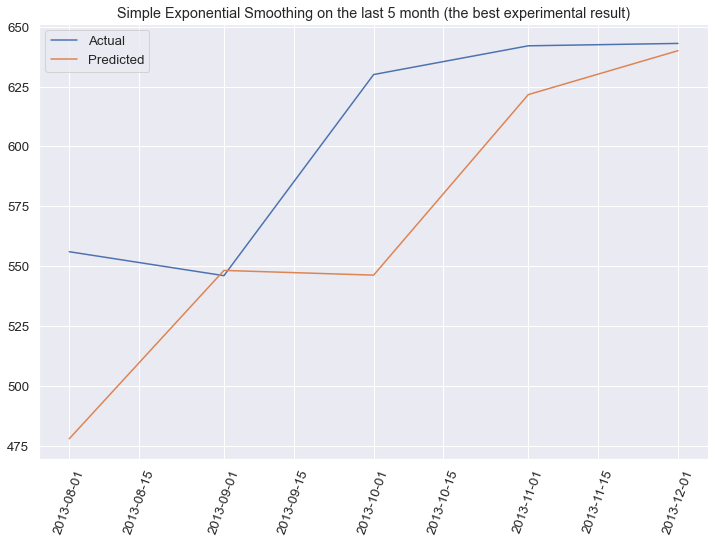

In [119]:
predicted_values = eval_result['predicted']
mape_error = np.mean(eval_result['mape'])
mae_error = np.mean(eval_result['mae'])
print(f'For alpha = 0.9:\nmape = {mape_error}\nmae = {mae_error}\n')
    
plot_results(x, y_true, predicted_values, title='Simple Exponential Smoothing on the last 5 month (the best experimental result)')

In [ ]:
from sklearn.pipeline import Pipeline

In [ ]:
values = data.Shipments.values

tscv = TimeSeriesSplit(n_splits=5, test_size=1) 
for train, test in tscv.split(values):
    X_train = values[train]
    pipe = Pipeline([('simple_exp_smooth', SimpleExpSmoothing(X_train))])
    pipe.fit(X_train)

In [77]:
def evaluate_mape(x):
    mape_errors = exp_smooth_score(x)['mape']
    return np.mean(np.array(mape_errors))

In [78]:
def plot_results(x, y_true, y_pred, title):
    plt.figure(figsize=(12,8))
    plt.plot(x, y_true, label='Actual')
    plt.plot(x, y_pred, label='Predicted')
    plt.tick_params(axis='x', rotation=70)
    plt.legend(loc='best')
    plt.title(title)
    plt.show()
    
x = data.Shipments[-5:].index.values
y_true = data.Shipments[-5:].values

#### Experimenting with parameters

Firstly, we'll choose some experimental parameters to compare error metrics. 

For alpha = 0.1:
mape = 0.32656559385702755
mae = 197.42902456988492

For alpha = 0.5:
mape = 0.1053270264777536
mae = 63.352515522746785

For alpha = 0.9:
mape = 0.06279279029131443
mae = 37.50113142322573



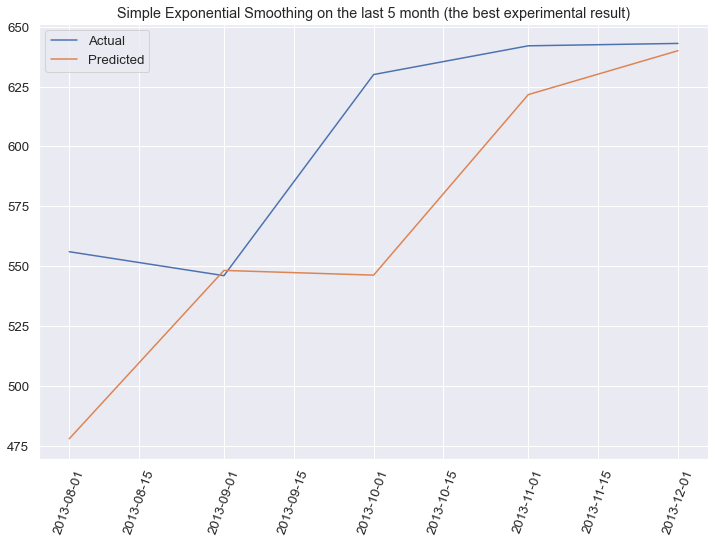

In [79]:
alphas = [0.1, 0.5, 0.9]
min_mape = 1

for alpha in alphas:
    exp_smooth = exp_smooth_score(np.array([alpha]))
    predicted_values = exp_smooth['predicted']
    mape_error = np.mean(exp_smooth['mape'])
    mae_error = np.mean(exp_smooth['mae'])
    print(f'For alpha = {alpha}:\nmape = {mape_error}\nmae = {mae_error}\n')
    
    if min_mape > mape_error:
        best_predicted_values = predicted_values
        min_mape = mape_error
    
plot_results(x, y_true, best_predicted_values, title='Simple Exponential Smoothing on the last 5 month (the best experimental result)')

So alpha of 0.9 gives better results of the error metrics, MAPE - **6.28%**. It's comparable to the result of applying SMA method - we got the best result taking the window's size of 1 which means that we looked only at previous observations. So in the case of Simple Exponential Smoothing large alpha tells us that we pay attention mainly to the most recent past observations without going deep into historical data.

But our data has clear trend and seasonality, which are don't consider in this method. Let's explore someothers extensions of Simple Exponential Smoothing.

### Double exponential smoothing

Double Exponential Smoothing is an extension to Simple Exponential Smoothing that **explicitly adds support for trends** in the univariate time series. In addition to the $\alpha$ parameter for controlling smoothing factor for the level, an additional smoothing factor is added to control the decay of the influence of the change in trend - $\beta$. <br> Before we dive deeeper into mathematical formulas, let's introduce two notations: **the current trend**, denoted by $b$ (we can think of it as the slope of the time series), and **the current level**, denoted by $l$. 

Some math behind this idea: 
$$l_x = \alpha y_x + (1 - \alpha)(l_{x-1} + b_{x-1})$$ 
$$b_x = \beta(l_x - l_{x-1}) + (1 - \beta)b_{x-1}$$ 
$$\hat{y}_{x+1} = l_x + b_x$$ 

- $l$, level is simply predicted point. It's a part of calculation of the forecast.
- Bigger values of $0<\beta<1$ mean that the model don't give much weight to the past trends when estimating current trend.
- The method supports **trend that changes in different ways: an additive and a multiplicative**, depending on whether the trend is linear or exponential respectively. Double Exponential Smoothing with an additive trend is classically referred to as **Holt’s linear trend model**. To compute the initial additive trend we may use the first two points: $y_x - y_{x-1}$. When the trend is multiplicative we could use the ratio $y_x / y_{x-1}$.

#### Experimenting with parameters

In [ ]:
alphas = [0.1, 0.9]
betas = [0.1, 0.9]
min_mape = 1

for alpha in alphas:
    for beta in betas:
        exp_smooth = exp_smooth_score([alpha, beta])
        predicted_values = exp_smooth['predicted']
        mape_error = np.mean(exp_smooth['mape'])
        mae_error = np.mean(exp_smooth['mae'])
        print(f'For alpha = {alpha}, beta = {beta}:\nmape = {mape_error}\nmae = {mae_error}\n')
        
        if min_mape > mape_error:
            best_predicted_values = predicted_values
            min_mape = mape_error
    
plot_results(x, y_true, best_predicted_values, title='Double Exponential Smoothing on the last 5 month (the best experimental result)')

Now our model takes into account trend of time-series, so alpha of 0.1 and beta of 0.9 give better result MAPE which is **4.056%**. Let's include seasonal component in our model and compare the results as well.

### Triple exponential smoothing

The idea behind this method (also called **Holt-Winters Method**) is to apply Exponential Smoothing to a third component - **seasonality**, $s$. This seasonal components in the model will explain repeated variations around intercept and trend, and it will be specified by the length of the season, in other words, by the period which the variations repeats itself. So for each observation in the season, there will be a separate component. 
<br> The mathematical notation for this method is:
$$l_x = \alpha (y_x - s_{x-L}) + (1 - \alpha)(l_{x-1} + b_{x-1})$$ 
$$b_x = \beta(l_x - l_{x-1}) + (1 - \beta)b_{x-1}$$ 
$$s_x = \gamma(y_x - l_{x}) + (1 - \gamma)s_{x-L}$$ 
$$\hat{y}_{x+m} = l_x + m b_x + s_{x-L+(m-1)modL}$$

- $L$, season length is the number of data points after which a new season begins.
- There is a new parameter  $0<\gamma<1$ that controls the influence on the seasonal component.
- The index for the forecast $\hat{y}_{x+m}$ is $x+m$ where $m$ can be any integer. It means we can forecast any number of points into the future while accounting for previous value, trend and seasonality.
- The index of the seasonal component $s_{x-L+(m-1)modL}$ offsets into our observed data list of seasonal components. 
<br> For example, if we are forecasting the 3rd point into the season, and we are 12 seasons into the future, we cannot use seasonal components from the 11th season in the future since that season is also generated by our forecasting procedure, we must use the last set of seasonal components from observed points, or from "the past".


**Initial values for the trend factor**
<br>The most common practice here is to compute the average trend averages across seasons:
$$b = \frac{1}{L}(\frac{y_{L+1} - y_1}{L} + \frac{y_{L+2} - y_2}{L} + \ldots + \frac{y_{L+L} - y_L}{L})$$

**Initial values for the seasonal indices**
<br> We need:
- to compute the averages for every observed season 
- to subtract every observed value by the average for the season it's in
- to  average each of these numbers across our observed seasons

#### Experimenting with parameters

In [ ]:
alphas = [0.1, 0.9]
betas = [0.1, 0.9]
gammas = [0.1, 0.9]

for alpha in alphas:
    for beta in betas:
        for gamma in gammas:
            exp_smooth = exp_smooth_score([alpha, beta, gamma])
            predicted_values = exp_smooth['predicted']
            mape_error = np.mean(exp_smooth['mape'])
            mae_error = np.mean(exp_smooth['mae'])
            print(f'For alpha = {alpha}, beta = {beta}, gamma = {gamma}:\nmape = {mape_error}\nmae = {mae_error}\n')
            
            if min_mape > mape_error:
                best_predicted_values = predicted_values
                min_mape = mape_error
    
plot_results(x, y_true, best_predicted_values, title='Triple Exponential Smoothing on the last 5 month (the best experimental result)')

We get **MAPE of 3.395%** when applied Exponential Smoothing both to trean and seasonality. So we may do better by optimizing our parameters. 
<br>Let's use local optimization method and adjust the parameters to the values 0.1, 0.9, 0.9.

In [ ]:
x = [0.09, 0.7, 0.7]
opt = minimize(evaluate_mape, x0=x, bounds=((0.09, 1), (0.7, 1), (0.7, 1)))
opt.x

In [ ]:
exp_smooth = exp_smooth_score(opt.x)
predicted_values = exp_smooth['predicted']
mape_score = np.mean(np.array(exp_smooth['mape']))
mae_score = np.mean(np.array(exp_smooth['mae']))
mape_score

In [ ]:
alpha, beta, gamma = opt.x
print(f'For alpha = {alpha}, beta = {beta}, gamma = {gamma}\nmape: {mape_score}\nmae: {mae_score}\n')

plot_results(x, y_true, predicted_values,, title='Triple Exponential Smoothing on the last 5 month')

### <font color='red'>!</font>
Oops, copy-paste!

In [ ]:
def exp_smooth_score(x):
    mape_errors = []
    mae_errors = []
    predicted_values = []
    eval_result = {}
    values = data.Shipments.values
    alpha, beta, gamma = x
    
    tscv = TimeSeriesSplit(n_splits=5, test_size=1) 
    for train, test in tscv.split(values):
    
        model = ExponentialSmoothing(values[train], trend='mul', 
                                         seasonal='additive', seasonal_periods=12).fit(smoothing_level=alpha, smoothing_trend=beta, smoothing_seasonal=gamma)
        # print(model.params)
        
        predictions = model.forecast(len(test)) 
        predicted_values.append(predictions)

        actual = values[test]
        mape_errors.append(mape(actual, predictions))
        mae_errors.append(mae(actual, predictions))
    
    eval_result['predicted'] = predicted_values
    eval_result['mape'] = mape_errors
    eval_result['mae'] = mae_errors

    return eval_result

#### Optimizing parameters

In [ ]:
evaluate_mape(exp_smooth_score([1, 1, 1])) # trend additive, seasson additive

In [ ]:
evaluate_mape(exp_smooth_score([1, 1, 1])) # trend mul, seasson additive

## Linear regression using Lag features

Another different method to forecast a time-series is to use past values called **Lags as predictors in Linear Regression model**.

### Use two lags - initial model

As we predict `Shipments` in the current month for the next one month and we know `Shipments` for the previous month but we don't know yet `Sales` for the previous month, we'll take **Lag_1** for `Shipments` and **Lag_2** for `Sales`.

<br> **Note: As we use lags as features, there're NaNs in our data and we should handle it.**
- **Zero** isn't a reasonable value to be replaced with.
- Replacing missing values with **mean or median** can data leak also computing mean and median doesn't consider trend/seasonality.
- **Last Observation Carried Forward and Next Observation Carried Backward techiques** also don't make sense within our task.
- As NaNs are continuous from the beggining to the N-th lag, **interpolation methods** are also not the way of handling missing data caused by lags.

Therefore, we'll just **drop NaNs** that appeared after creating of lags.

### <font color='red'>!</font>
With whole pipeline (from data preparation, feature selection, etc.) it's easier to follow the data flow in the model, whereas having consecutive transforming functions makes it reader's responsibility.

Check out pipelines, transformers, estimators from sklearn.

In [ ]:
def make_lags(ts, lags):
    return pd.concat(
        {
            f'{ts.name}_lag_{i}': ts.shift(i)
            for i in lags
        },
        axis=1)

In [ ]:
from sklearn.preprocessing import FunctionTransformer
transformer = FunctionTransformer(make_lags)

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

clf = make_pipeline(LinearRegression())
np.mean(-cross_val_score(clf, X, y, scoring='neg_mean_absolute_percentage_error', cv=tscv))

In [ ]:
data_lag = data.copy()
sales_lags = make_lags(data_lag.Sales, [2])
shipments_lags = make_lags(data_lag.Shipments, [1])

res = pd.concat([sales_lags, shipments_lags, data_lag[['BlackFriday']]], axis=1)
res.dropna(inplace=True)

X, y = res, data_lag[['Shipments']][2:]

### <font color='red'>!</font>
Reusing evaluation for different models (pipelines) helps track each model's contribution: you can see how final metric changes with changing only the model, and all the inputs / metrics calculation stays the same.

In [ ]:
def evaluate(model, X, y):
    tscv = TimeSeriesSplit(n_splits=5, test_size=1) 

    mae_errors, mape_errors = [], []
    predicted_values = []
    for train, test in tscv.split(X):
        model.fit(X.values[train], y.values[train])
        prediction = model.predict(X.values[test])
        predicted_values.append(prediction[0])
    
        mae_errors.append(mae(y.values[test], prediction))
        mape_errors.append(mape(y.values[test], prediction))
    
    mae_errors = np.mean(np.array(mae_errors))
    mape_errors = np.mean(np.array(mape_errors))

    print(f'mape = {mape_errors}\nmae = {mae_errors}\n')
    return predicted_values

In [ ]:
lin_reg = LinearRegression()

In [ ]:
predicted_values = evaluate(lin_reg, X, y)
plot_results(x, y_true, predicted_values, title='Linear regression with initial 2 lag features on the last 5 month')

So we took only 2 lags and got MAPE of 8.47% but I assume that we can improve our error metric results by choosing more lags.

### Choosing lags

When choosing lags to use as features, it generally won't be useful to include every lag because we may end up with large autocorrelation. We'll use different techhiques to choose lags in order to get the best model performance.

### Partial Autocorrelation plot

Plotting the partial autocorrelation may help us to choose which lag features to use.
<br> Partial autocorrelation can be imagined as the **pure correlation** between the series and its lag, after excluding the contributions from the intermediate lags. So it's the relation between observed at two-time spots given that we consider both observations are correlated to the observations at other time spots.

In [ ]:
plot_pacf(data.Sales, method='ols') 
plt.title('Partial Autocorrelation for Sales')

plot_pacf(data.Shipments, method='ols') 
plt.title('Partial Autocorrelation for Shipments')
plt.show()

We used the **ols** (ordinary least squares) method as it fits a linear regression model with intercept using the original series as the target and the lagged series as the features. The main difference between two ols methods (efficient and inefficient) is that in the efficient approach we iteratively decreased the number of observations whereas in the inefficient we remove the first N (amount of lags) observations at the beginning.
<br><p>In the partial autocorrelation plot, the light blue area shows the significant threshold value, and every vertical line indicates the PACF values at each time spot. So in the plot, only the vertical lines that exceed the light blue area are considered significant. Lag_0 is time-series itself so the correlation is always equal to 1.

- For `Sales` we'll choose **Lag_2, Lag_3, Lag_5**. Even though at Lag_1 we'll see high correlation, we don't choose it as we don't know `Sales` for the previous month according to the task.
- For `Shipments` we'll choose **Lag_1** as we did before.

In [ ]:
data_lag = data.copy()
X = make_lags(data_lag.Sales, [2, 3, 5])
y = make_lags(data_lag.Shipments, [1])

In [ ]:
res = pd.concat([X, y], axis=1)
res = pd.concat([res, data_lag[['BlackFriday']]], axis=1)
res.dropna(inplace=True)

In [ ]:
X, y = res, data_lag[['Shipments']][5:]

In [ ]:
predicted_values = evaluate(lin_reg, X, y)
plot_results(x, y_true, predicted_values, title='Linear regression with lag features from PACF on the last 5 month')

As we choosed more lags for `Sales` we decreased error metrics. But for now we did it manually with the help of partial autocorrelation plot. Let's use some feature selection methods and see what lags as features will be choosen. 

### Feature Selection techniques

We'll cover:
- Lasso + SelectFromModel
- RandomForestRegressor + Boruta

The idea is to use a baseline model to evaluate features, so the model should clearly show the importance of the features used. As a basiline model wi'll use: linear model Lasso, that tends to produce zero coefficients, and RandomForrest. The logic is clear: if the features are clearly useless in a simple model, then there is no need to drag them into a more complex one.

#### Lasso + SelectFromModel

SelectFromModel keeps features whose importance (estimated by Lasso) is greater or equal than a specific threshold (mean, median or in a case with Lasso threshold equals to 1e-5), while others are discard.

In [ ]:
data_lag = data.copy()

sales_lags_count = list(range(2, 6))
shipments_lags_count = list(range(1, 6))
sales_lags = make_lags(data_lag.Sales, sales_lags_count)
shipments_lags = make_lags(data_lag.Shipments, shipments_lags_count)

res = pd.concat([sales_lags, shipments_lags], axis=1)
res.dropna(inplace=True)

In [ ]:
scaler = StandardScaler()
res_scaled = pd.DataFrame(scaler.fit_transform(res[:-5]), columns=res.columns)
df_scaled = pd.concat([res_scaled, data_lag.BlackFriday[5:-5].reset_index(drop=True)], axis=1)

In [ ]:
X, y = df_scaled, scaler.fit_transform(data_lag[['Shipments']][5:-5])

In [ ]:
selection_model = Lasso(alpha=0.1).fit(X, y)
model = SelectFromModel(selection_model, prefit=True)

In [ ]:
columns_to_keep = df_scaled.columns[model.get_support()].values.tolist()
columns_to_keep

In [ ]:
delete = [c for c in res.columns.values.tolist() if c not in columns_to_keep]
reduced_data = res.drop(delete, axis=1)

In [ ]:
X, y = reduced_data, data_lag['Shipments'][5:]

In [ ]:
predicted_values = evaluate(lin_reg, X, y)
plot_results(x, y_true, predicted_values, title='Linear regression with lag features using Lasso + SelectFromModel on the last 5 month')

The results of MAPE are better after applying Lasso model. Let's try to tune Lasso parameters to get better result. One way to do this is to use GridSearch method.

#### GridSearch + Lasso

In a nutshell Grid Search allows to pass through all different combinations of given model parameters and their values and choose the best combination. One of the major drawbacks of grid search is that when it comes to dimensionality, it suffers when the number of hyperparameters grows exponentially.

In [ ]:
parameters = {
    'alpha': np.linspace(0.1, 1, 10), 
    'fit_intercept':['True', 'False'],
    'max_iter': np.linspace(100, 1500, 8),
    'tol':np.linspace(0.0001, 0.001, 4)
}

In [ ]:
tscv = TimeSeriesSplit(n_splits=5, test_size=1) 

grid = GridSearchCV(Lasso(), 
                    parameters, 
                    cv=tscv, 
                    scoring='neg_mean_absolute_percentage_error')

In [ ]:
X, y = df_scaled, scaler.fit_transform(data_lag[['Shipments']][5:-5])
grid_result = grid.fit(X, y)

In [ ]:
grid_result.best_params_

So as the best parameters of GridSearch are the same that we used previously with Lasso model, we'll move on and try another baseline model as an estimator - RandomForest, and one more selection technique Boruta.

#### RandomForestRegressor + Boruta

The idea underlying Boruta is to create random copies (**shadow features**) of all the features from the original dataset and train classifiers based on this extended dataset. We take the importance of each original features and compare it with a threshold. The threshold is defined as the highest feature importance recorded among the shadow features. When the importance of a feature is higher than this threshold, this is called a **hit**. The idea is that **a feature is useful only if it’s capable of doing better than the best randomized feature**.
<br><p>**What's the probability that we shall keep a feature?** The maximum level of uncertainty about the feature is expressed by a probability of 50%, like tossing a coin. Since each independent experiment can give a binary outcome (hit or no hit), a series of $n$ trials follows a **binomial distribution**.
<br><p>There're 3 areas: an **area of refusal**, an **area of irresolution**, an **area of acceptance**.

In [ ]:
forest = RandomForestRegressor(
    n_jobs=-1, 
    max_depth=5,
    random_state=42
)
boruta = BorutaPy(
    estimator=forest, 
    n_estimators='auto',
    max_iter=100,
    random_state=42
)

In [ ]:
res = pd.concat([res, data_lag.BlackFriday[5:]], axis=1)
X, y = res, data_lag['Shipments'][5:]

In [ ]:
X_train, y_train = X[:-5], y[:-5]
boruta.fit(np.array(X_train), np.array(y_train))

In [ ]:
cols = X.columns[boruta.support_].to_list()
cols

In [ ]:
delete = [c for c in res.columns.values.tolist() if c not in cols]
reduced_data = res.drop(delete, axis=1)

In [ ]:
X, y = reduced_data, data_lag['Shipments'][5:]

In [ ]:
predicted_values = evaluate(lin_reg, X, y)
plot_results(x, y_true, predicted_values, title='Linear regression with lag features using Boruta on the last 5 month')

Applying Boruta with RandomForest we decreased our error metrics. Let's try to tune parameters of RandomForest in order to improve the results a bit more.

#### GridSearch + RandomForestRegressor

In [ ]:
parameters = {
    'n_estimators': [10, 40, 70, 100, 130],
    'criterion': ['squared_error', 'absolute_error', 'poisson'],
    'max_depth': [3, 5, 7, 11],
    'min_samples_split': [2, 4, 6]
}

In [ ]:
RandomForestRegressor

In [ ]:
tscv = TimeSeriesSplit(n_splits=5, test_size=1) 

grid = GridSearchCV(RandomForestRegressor(random_state=42, n_jobs=-1), 
                    parameters, 
                    cv=tscv, 
                    scoring='neg_mean_absolute_percentage_error')

grid_result = grid.fit(X_train, y_train)

In [ ]:
grid_result.best_params_

In [ ]:
pd.DataFrame(grid_result.cv_results_).query('param_n_estimators == 100 & param_max_depth == 5 & param_min_samples_split	 == 2')

In [ ]:
pd.DataFrame(grid_result.cv_results_).sort_values('rank_test_score')

In [ ]:
forest = RandomForestRegressor(**grid_result.best_params_, random_state=42)

boruta = BorutaPy(
    estimator=forest, 
    n_estimators='auto',
    max_iter=100,
    random_state=42
)

In [ ]:
boruta.fit(np.array(X_train), np.array(y_train))

In [ ]:
cols = X.columns[boruta.support_].to_list()
cols

In [ ]:
delete = [c for c in res.columns.values.tolist() if c not in cols]
reduced_data = res.drop(delete, axis=1)

In [ ]:
X, y = reduced_data, data_lag['Shipments'][5:]

In [ ]:
predicted_values = evaluate(lin_reg, X, y)
plot_results(x, y_true, predicted_values, title='Linear regression with lag features using Boruta on the last 5 month')

Tunning parameters with GridSearch didn't help us to decrease MAPE more, we got even higher values of error metrics than SelectFromModel and Lasso gave. 
<br> So for now we used Linear regression as a main part of our predictions, but let's focus on idea of gradient boosting.

## Gradient Boosting libraries

### XGBoost

In [ ]:
xgb_reg = xgb.XGBRegressor(learning_rate=1, n_estimators=50, booster='gblinear', random_state=42)

In [ ]:
predicted_values = evaluate(xgb_reg, X, y)
plot_results(x, y_true, predicted_values, title='XGBoost with lag features on the last 5 month')

In [ ]:
params = {
        'n_estimators': [50, 100],
        'max_depth': [3, 5, 7, 9],
        'eta': [0.1, 0.3, 0.5, 0.7, 1]
        }

In [ ]:
tscv = TimeSeriesSplit(n_splits=5, test_size=1) 

grid = GridSearchCV(xgb.XGBRegressor(objective='reg:squarederror', random_state=42), 
                    params, 
                    cv=tscv, 
                    scoring='neg_mean_absolute_percentage_error')

X_train, y_train = X[:-5], y[:-5]
grid_result = grid.fit(X_train, y_train)

In [ ]:
grid_result.best_params_

In [ ]:
xgb_reg = xgb.XGBRegressor(**grid_result.best_params_)

In [ ]:
predicted_values = evaluate(xgb_reg, X, y)
plot_results(x, y_true, predicted_values, title='XGBoost with lag features on the last 5 month')

## Phrophet

In [ ]:
data_prophet = data.copy()

In [ ]:
data_prophet.reset_index(inplace=True)
data_prophet = data_prophet.rename(columns = {'Date': 'ds',
                                              'Shipments': 'y'})
data_prophet = data_prophet.loc[:, ['ds', 'y']]

### Initial prophet

In [ ]:
def validate_prophet(holidays=None):
    values = data_prophet.values
    tscv = TimeSeriesSplit(n_splits=5, test_size=1, gap=1) 

    mae_errors, mape_errors = [], []
    predicted_values = []
    for train, test in tscv.split(values):
        df_train = pd.DataFrame(values[train]).rename(columns = {0: 'ds', 1: 'y'})
        model = Prophet(holidays=holidays)
        model.fit(df_train)
    
        future_date = pd.DataFrame(data_prophet.iloc[test[0]]).T[['ds']]
        prediction = model.predict(future_date)
        predicted_values.append(prediction.yhat)
    
        mae_errors.append(mae(np.array([data_prophet.iloc[test[0]].values[1]]), np.array([prediction.yhat.values[0]])))
        mape_errors.append(mape(np.array([data_prophet.iloc[test[0]].values[1]]), np.array([prediction.yhat.values[0]])))
    
    mae_errors = np.mean(np.array(mae_errors))
    mape_errors = np.mean(np.array(mape_errors))

    print(f'mape = {mape_errors}\nmae = {mae_errors}\n')
    return predicted_values

In [ ]:
predicted_init = validate_prophet()

### Phrophet with holidays

In [ ]:
black_friday = promo_data.reset_index()
black_friday.columns = ['ds', 'holiday']

predicted_adv = validate_prophet(holidays=black_friday)

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(true_values, label='Actual')
plt.plot(predicted_init, label='Predicted (initial)')
plt.plot(predicted_adv, label='Predicted (with holidays)')
plt.legend(loc='best')
plt.title('Simple Exponential Smoothing on the last 5 month')
plt.show()